In [1]:
import os
import glob
import cv2 
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
BATCH_SIZE = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def readImage(location,y_temp):
    image = nib.load(location)
    temp = np.array(image.get_fdata())[:,:,:,0]
    return (temp/temp.max()).astype(np.float32),y_temp

In [4]:
paths = np.array(glob.glob('./Dataset/*/*/*/*.nii'))

In [5]:
##Creating the pipeline
paths_train,paths_test,_,_ = train_test_split(paths,[0]*paths.shape[0],test_size=0.25)

In [6]:
def getLabel(path):
    path_decoded = path.numpy().decode()
    #print(path_decoded)
    name = path_decoded.split('\\')[1]
    #print(name)
    classes = np.array(["AD"])
    return readImage(path_decoded,(classes == name).astype(np.float32))


In [7]:
def tf_reshape(img,y):
    return tf.reshape(img,(128,128,63,1)),tf.reshape(y,(1,))

In [8]:
readImage_wrapper = lambda x,y : tf.py_function(readImage,[x,y],[tf.float32,tf.float32])
getLabel_wrapper = lambda x : tf.py_function(getLabel, [x], [tf.float32,tf.float32])


In [9]:
def create_dataset(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(getLabel_wrapper, num_parallel_calls=AUTOTUNE)
    #dataset = dataset.map(readImage_wrapper, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(tf_reshape , num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [10]:
train_set = create_dataset(paths_train)
test_set = create_dataset(paths_test)


## Making the Model

In [11]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv3D,Dense,MaxPool3D,ReLU,Input,concatenate,Flatten,BatchNormalization, Dropout, GlobalAveragePooling3D

In [12]:
#For low intensity segments
input_layer = Input(shape=(128,128,63,1),name='input')
model = Conv3D(filters=128, kernel_size=3, strides=2,padding='same', activation=None, name="GroupConv1")(input_layer)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=128, kernel_size=3, strides=1,padding='same', activation=None , name="GroupConv2")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=256, kernel_size=3, strides=2,padding='same', activation=None, name="GroupConv3")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=256, kernel_size=3, strides=1,padding='same', activation=None , name="GroupConv4")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

classifier = Conv3D(filters=512, kernel_size=3, strides=2,padding='same', activation=None)(model)
classifier = BatchNormalization(center=True, scale=True)(classifier)
classifier = ReLU()(classifier)
classifier = Dropout(0.5)(classifier)

flatten = GlobalAveragePooling3D()(classifier)

dense = Dense(256, activation='relu')(flatten)
output = Dense(1, activation='sigmoid')(dense)

In [13]:
model = Model(input_layer,output)

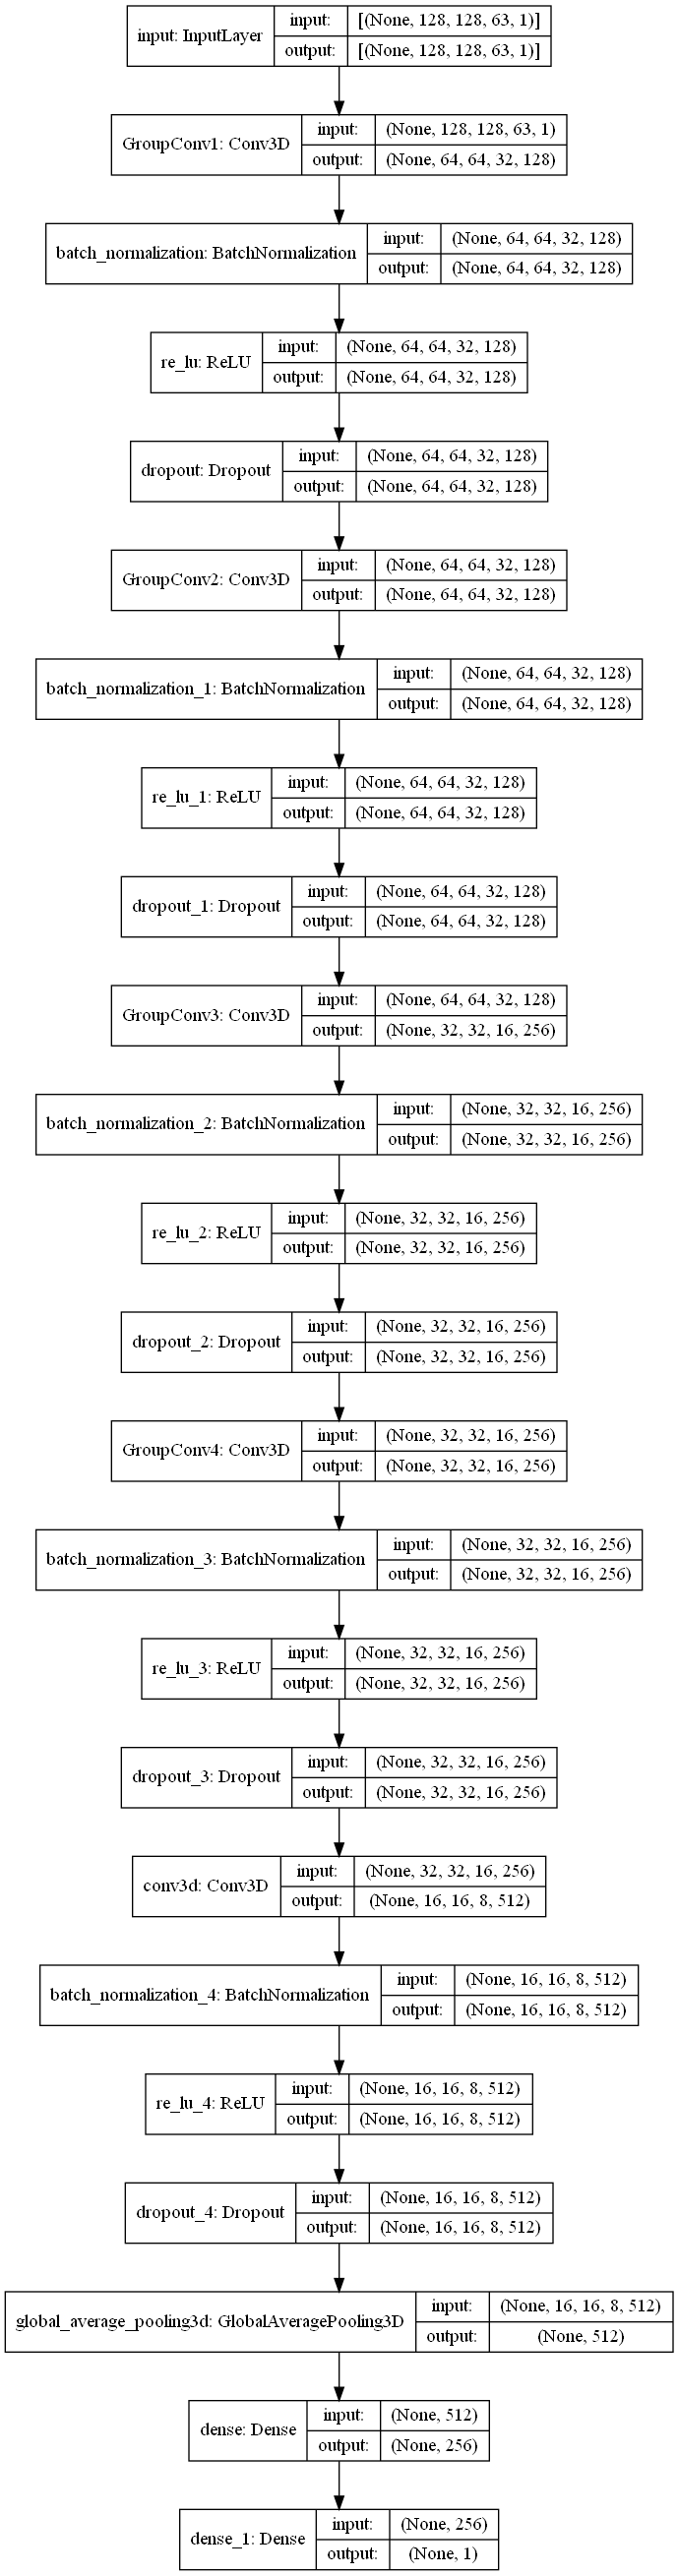

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
#opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [16]:
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(train_set,
          batch_size=BATCH_SIZE,
          epochs=10,
          validation_data=test_set)

Epoch 1/10
214/214 [==============================] - 88s 384ms/step - loss: 0.8032 - accuracy: 0.5088 - val_loss: 0.7732 - val_accuracy: 0.6294
Epoch 2/10
214/214 [==============================] - 81s 379ms/step - loss: 0.7334 - accuracy: 0.5273 - val_loss: 0.7392 - val_accuracy: 0.6294
Epoch 3/10
214/214 [==============================] - 82s 381ms/step - loss: 0.7006 - accuracy: 0.5664 - val_loss: 0.7117 - val_accuracy: 0.6294
Epoch 4/10
214/214 [==============================] - 82s 382ms/step - loss: 0.6901 - accuracy: 0.5664 - val_loss: 0.8146 - val_accuracy: 0.6294
Epoch 5/10
214/214 [==============================] - 82s 382ms/step - loss: 0.6892 - accuracy: 0.5664 - val_loss: 0.7085 - val_accuracy: 0.6294
Epoch 6/10
214/214 [==============================] - 82s 382ms/step - loss: 0.6873 - accuracy: 0.5664 - val_loss: 0.7383 - val_accuracy: 0.6294
Epoch 7/10
214/214 [==============================] - 82s 383ms/step - loss: 0.6895 - accuracy: 0.5662 - val_loss: 0.7526 - val_ac